# Signal/Background Classification using Boosted Decision Trees

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, f1_score
from sklearn.inspection import permutation_importance

seed = 1234
np.random.seed(seed)

In [6]:
import os
print(os.getcwd())

/teamspace/studios/this_studio/all/BDT/DifferentAxionMass


## 1. Data Loading

In [7]:
ax75_data = pd.read_csv('/teamspace/studios/this_studio/all/BDT/DifferentAxionMass/ax75_signalBackground_2j1p_invMass_deltaR_data.txt', 
                     sep = '\t')

In [8]:
ax75_data.head()

,Unnamed: 0,eventno,jetmultiplicity,event_label,num_btag_jets,num_isophoton,jet1_Eta,jet1_Phi,jet1_pT,jet1_Px,...,jet2_E,isophoton1_Eta,isophoton1_Phi,isophoton1_pT,isophoton1_Px,isophoton1_Py,isophoton1_Pz,isophoton1_E,inv_mass_2j1p,deltaR_j1j2
0,0,54229.0,2.0,0.0,2.0,1.0,-0.452222,0.645538,26.0517,20.80950,...,27.5445,-0.476993,-1.66211,27.4569,-2.503820,-27.34250,-13.59910,30.6402,76.497345,1.729497
1,1,451531.0,2.0,0.0,2.0,1.0,-0.319102,-1.892100,27.9884,-8.83895,...,34.6989,-0.250455,1.85829,28.0520,-7.954070,26.90070,-7.09946,28.9365,81.254966,0.849681
2,2,29203.0,2.0,0.0,2.0,1.0,0.750920,-2.306760,66.2397,-44.46700,...,0.0000,0.490037,1.60387,27.8527,-0.921051,27.83750,14.20170,31.2644,80.421951,2.425907
3,3,52691.0,2.0,1.0,2.0,1.0,1.479940,-0.827068,51.1242,34.61300,...,118.0260,-0.107709,-2.97132,15.9033,-15.673400,-2.69486,-1.71624,15.9957,123.826058,2.981831
4,4,238096.0,3.0,0.0,2.0,1.0,2.199850,-0.426989,53.9469,49.10340,...,55.9621,1.153420,2.21908,36.4435,-22.005300,29.04980,51.99460,63.4946,272.110419,4.662546


In [9]:
ax75_data = ax75_data.drop(['Unnamed: 0'], axis = 1)

In [10]:
features_col = ['isophoton1_pT', 'inv_mass_2j1p', 'deltaR_j1j2']


X, y = ax75_data.loc[:,features_col].values, ax75_data.loc[:,'event_label'].values.astype(int)

In [11]:
from collections import Counter
Counter(y)[0]
print(f"Counts:"
     f"\n    Signal: {Counter(y)[1]}"
f'\n    Background: {Counter(y)[0]}')

Counts:
    Signal: 4790
    Background: 1912


## 2. Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=seed,
                                                    stratify = y)

# Random Forest Classifier

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
param_grid_forest = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 20]
}
grid_search_forest = GridSearchCV(RandomForestClassifier(random_state=seed),
                                  param_grid=param_grid_forest,
                                  cv=5,
                                  n_jobs=-1,
                                  verbose = 4
                                 )

In [15]:
grid_search_forest.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END max_depth=3, min_samples_split=2, n_estimators=50;, score=0.789 total time=   0.3s
[CV 3/5] END max_depth=3, min_samples_split=2, n_estimators=100;, score=0.808 total time=   0.5s
[CV 1/5] END max_depth=3, min_samples_split=2, n_estimators=200;, score=0.788 total time=   1.1s
[CV 5/5] END max_depth=3, min_samples_split=2, n_estimators=200;, score=0.800 total time=   1.0s
[CV 4/5] END max_depth=3, min_samples_split=2, n_estimators=300;, score=0.779 total time=   1.7s
[CV 3/5] END max_depth=3, min_samples_split=2, n_estimators=500;, score=0.805 total time=   2.8s
[CV 4/5] END max_depth=3, min_samples_split=5, n_estimators=50;, score=0.779 total time=   0.3s
[CV 1/5] END max_depth=3, min_samples_split=5, n_estimators=100;, score=0.786 total time=   0.6s
[CV 5/5] END max_depth=3, min_samples_split=5, n_estimators=100;, score=0.802 total time=   0.7s
[CV 3/5] END max_depth=3, min_samples_split=5, n_estimators=200;, s

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 200, 300, 500]},
             verbose=4)

Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 100}


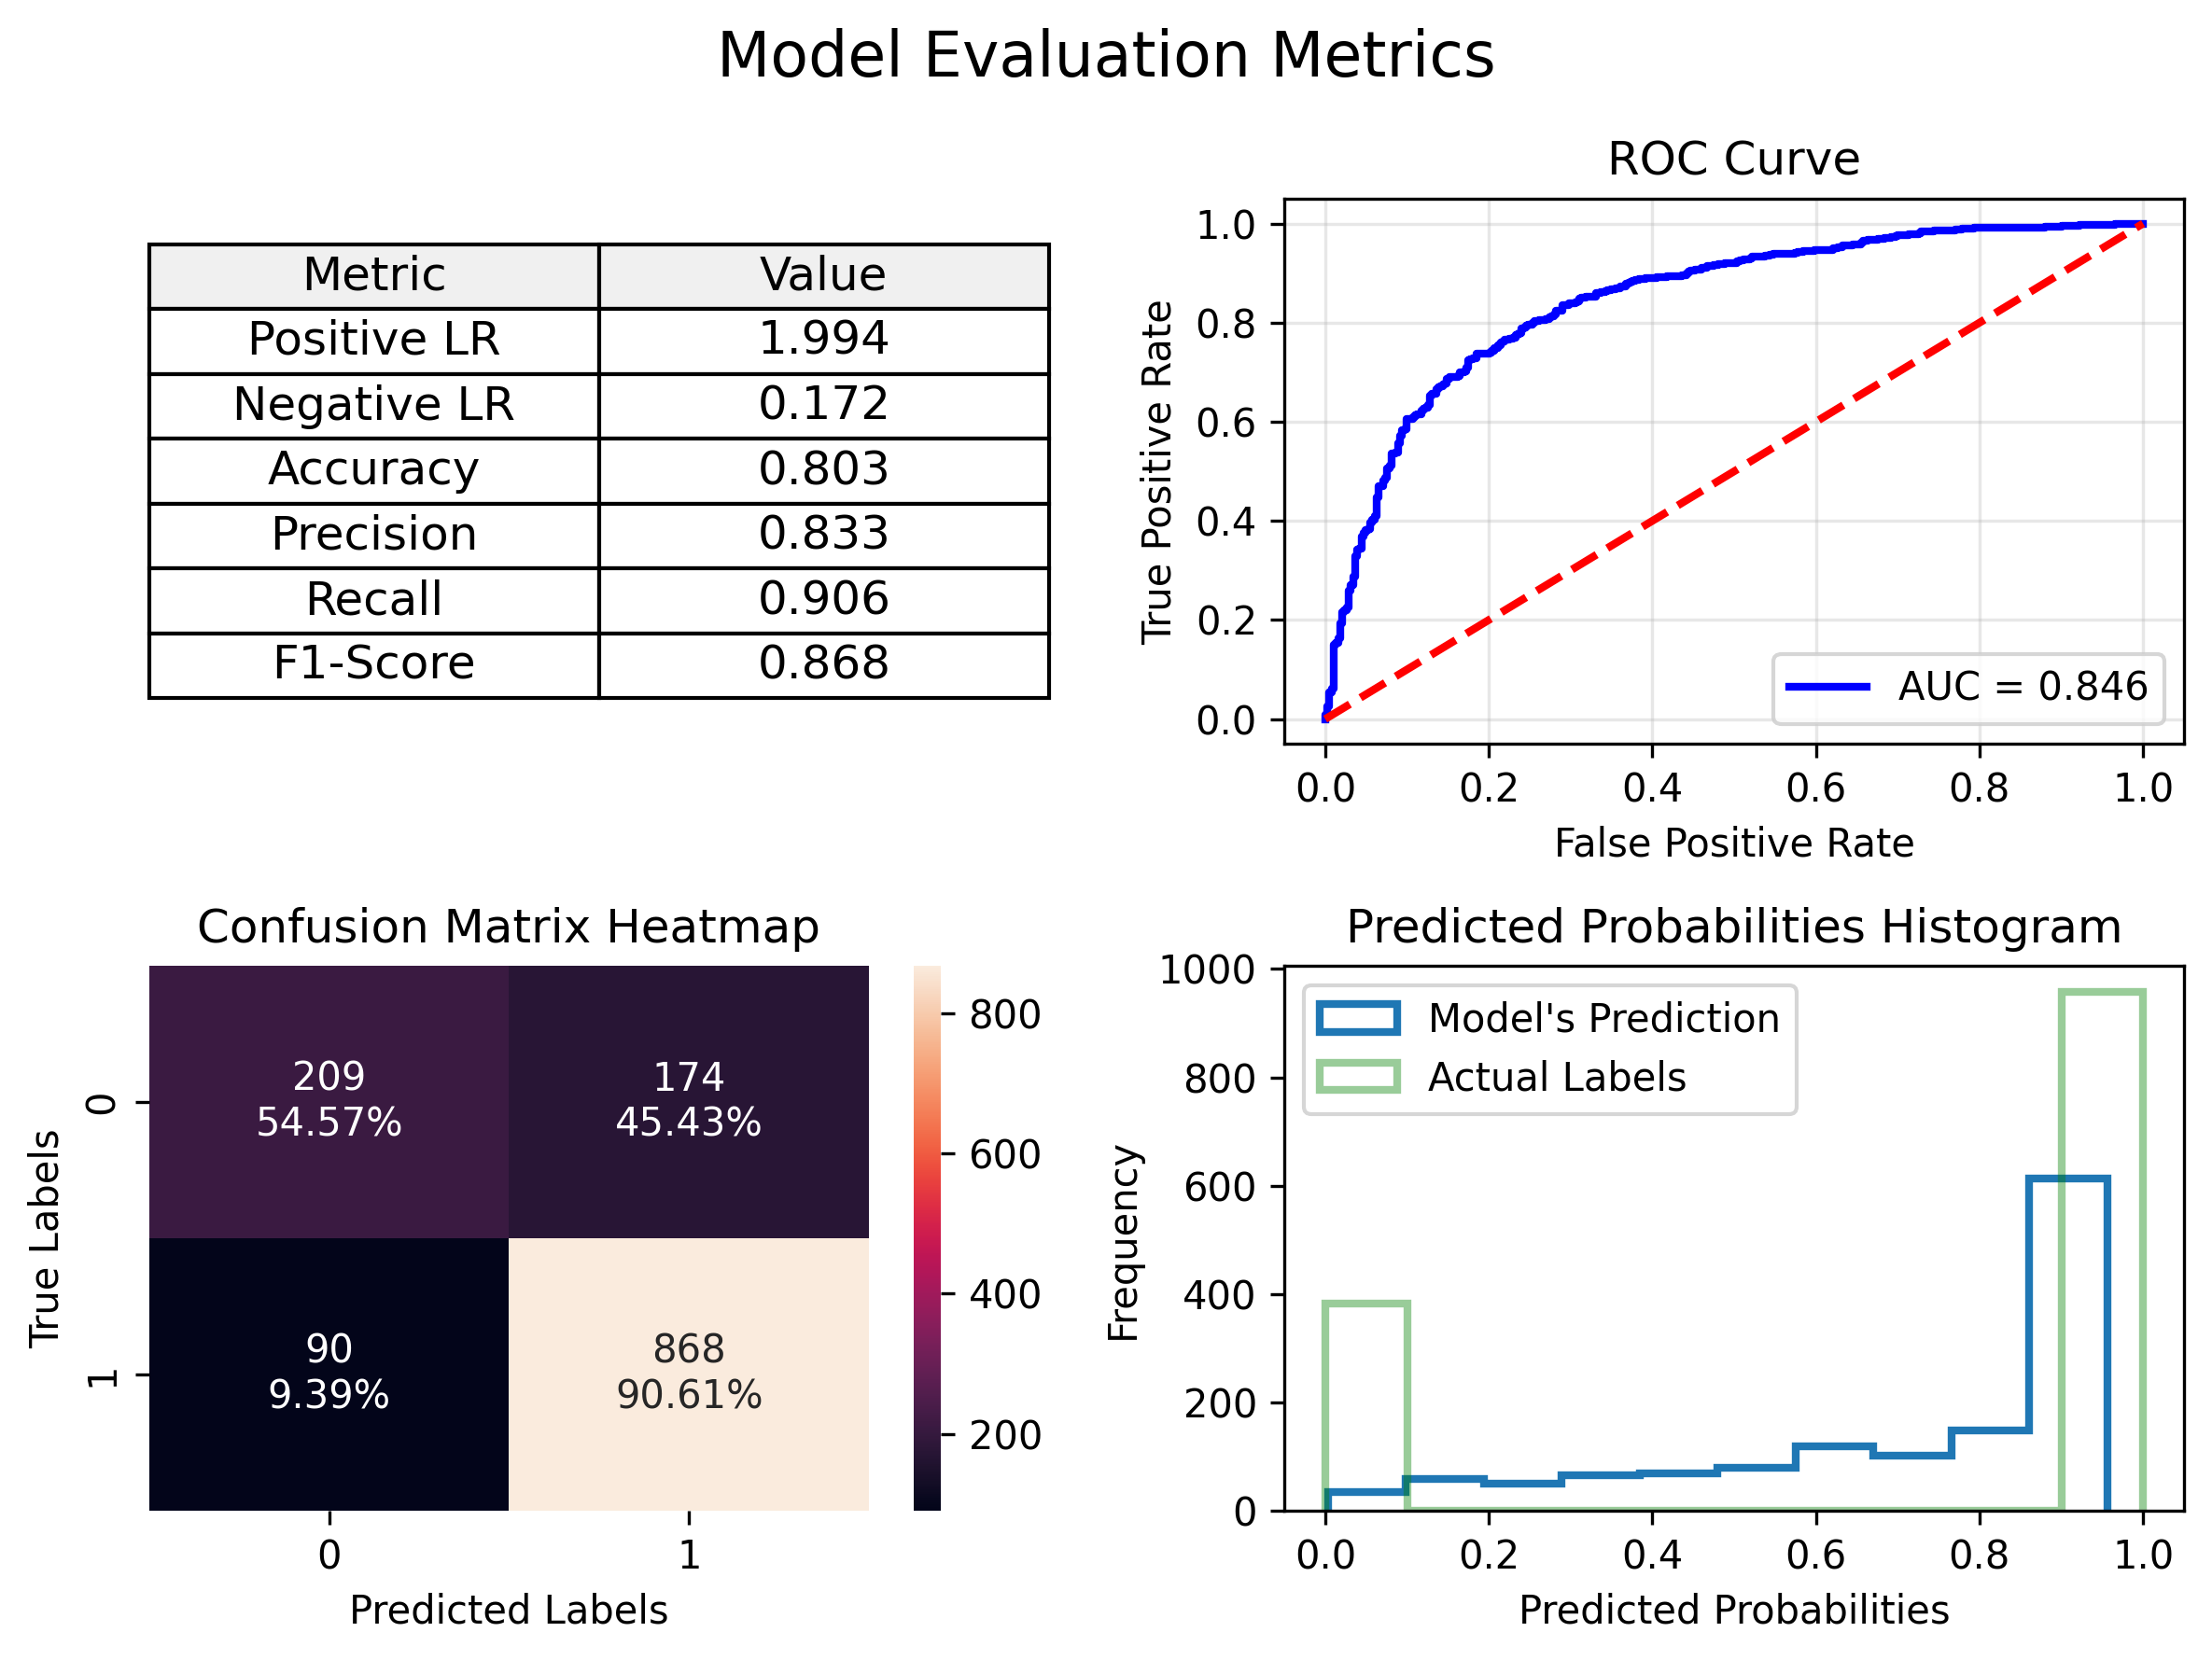

In [16]:
from helper_function_module import eval_model
best_model_RF = grid_search_forest.best_estimator_
y_pred = best_model_RF.predict(X_test)
y_pred_prob = best_model_RF.predict_proba(X_test)[:, 1] #For getting probabilites of class label 1


print(f'Best Hyperparameters: {grid_search_forest.best_params_}')

y_pred_label = [1 if (y_prob >= 0.5) else 0 for y_prob in y_pred_prob]
eval_model(y_test, y_pred_prob, y_pred_label, save_fig = False, save_fig_path = 'ax75_RFEval_Metrics.png')

# Gradient Boosting Classifier

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

In [18]:
param_grid_grad = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.001]
}

In [19]:
grid_search_grad = GridSearchCV(GradientBoostingClassifier(random_state=seed),
                                param_grid=param_grid_grad,
                                cv=5,
                                n_jobs=-1,
                               verbose = 4)

In [20]:
grid_search_grad.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             verbose=4)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


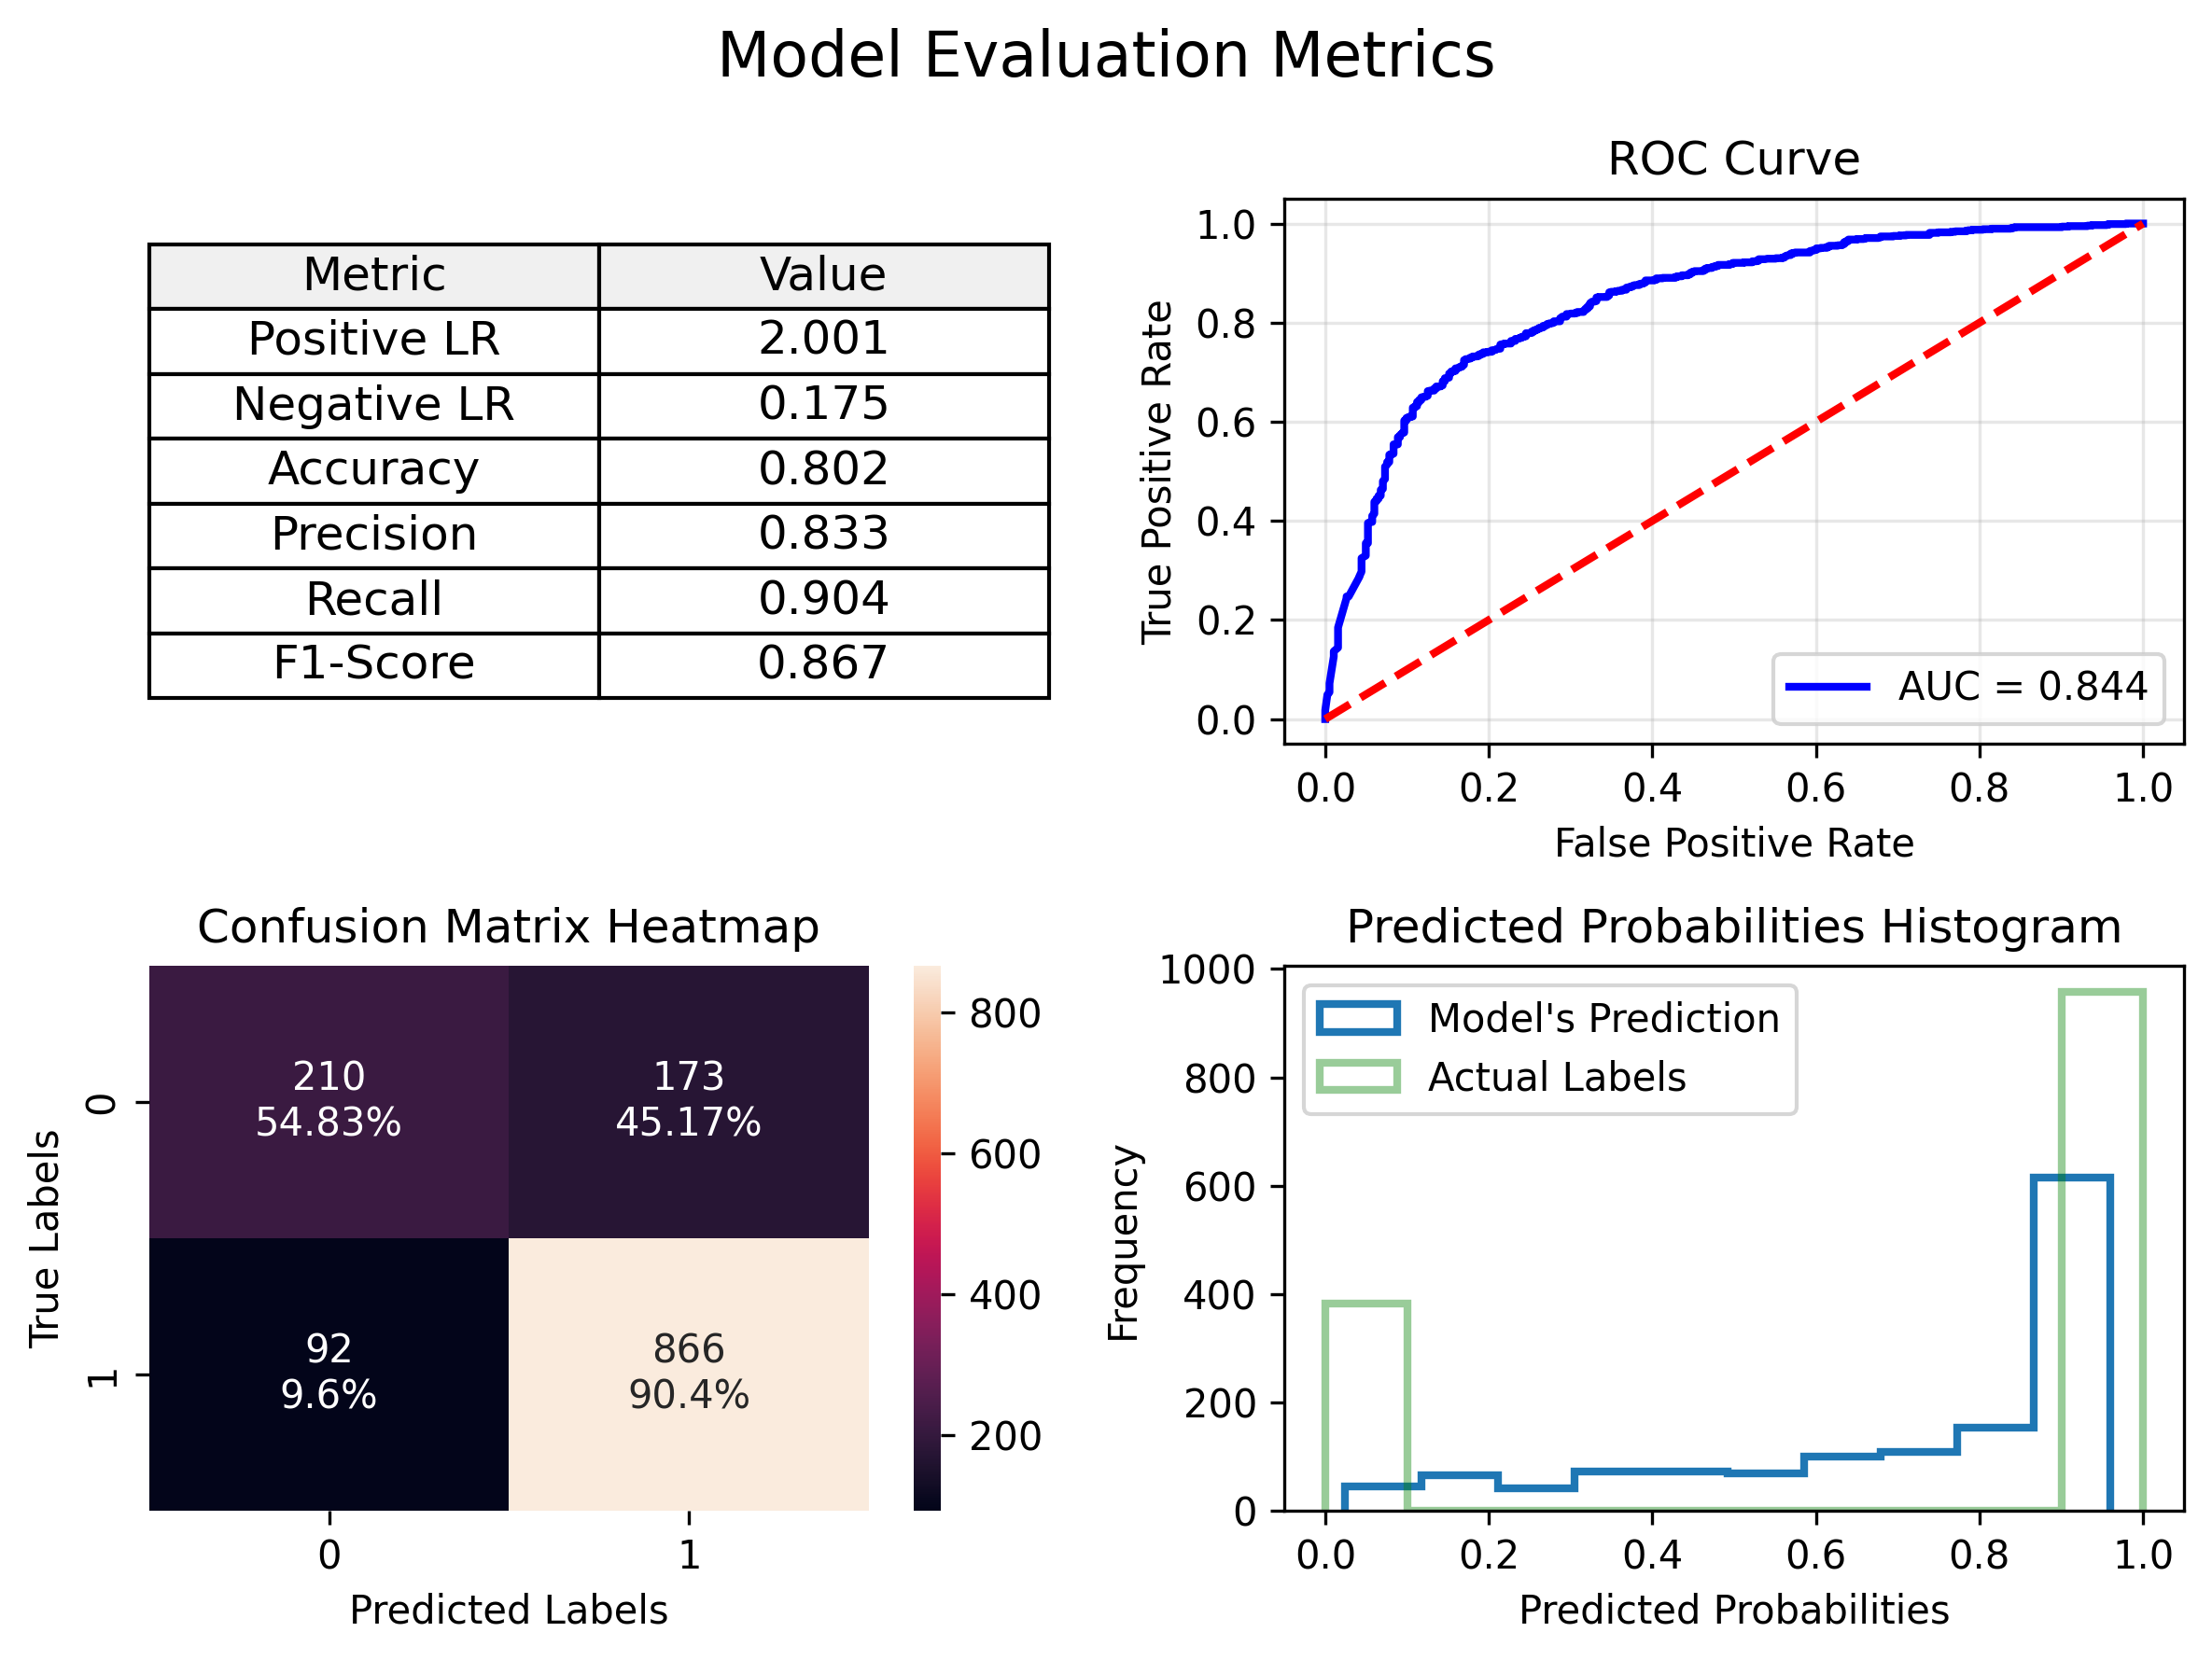

In [21]:
from helper_function_module import eval_model
best_model_GB = grid_search_grad.best_estimator_
y_pred = best_model_GB.predict(X_test)
y_pred_prob = best_model_GB.predict_proba(X_test)[:, 1] #For getting probabilites of class label 1

print(f'Best Hyperparameters: {grid_search_grad.best_params_}')

y_pred_label = [1 if (y_prob >= 0.5) else 0 for y_prob in y_pred_prob]
eval_model(y_test, y_pred_prob, y_pred_label, save_fig = False, save_fig_path = 'ax75_GBEval_Metrics.png')

# Extracting Feature Importances - RandomForest


--- Calculating Impurity-Based Feature Importance (MDI) ---
inv_mass_2j1p    0.413665
isophoton1_pT    0.326238
deltaR_j1j2      0.260097
dtype: float64


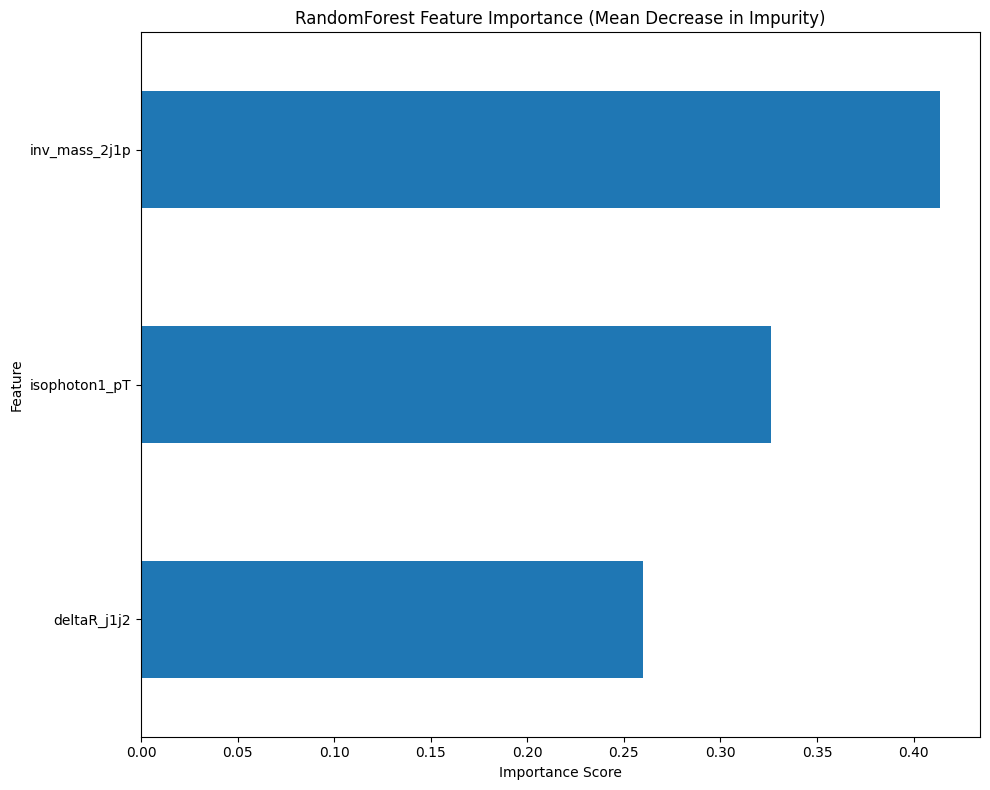

In [22]:
print("\n--- Calculating Impurity-Based Feature Importance (MDI) ---")
# Get importance scores directly from the trained model
rf_importances_mdi = best_model_RF.feature_importances_

# Create a Pandas Series for easy handling and sorting
rf_importances_mdi = pd.Series(rf_importances_mdi, index=features_col)
rf_importances_mdi = rf_importances_mdi.sort_values(ascending=False)

print(rf_importances_mdi)

# --- Visualize MDI Importances ---
plt.figure(figsize=(10, 8))
rf_importances_mdi.plot(kind='barh')
plt.title("RandomForest Feature Importance (Mean Decrease in Impurity)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.tight_layout()
plt.show()

## Permutation Importance - RandomForest


--- Calculating Permutation Importance (on Test Set) ---

Features Permutation Importance on Test Set, metric='roc_auc'):
inv_mass_2j1p    0.128480
isophoton1_pT    0.060130
deltaR_j1j2      0.051578
dtype: float64


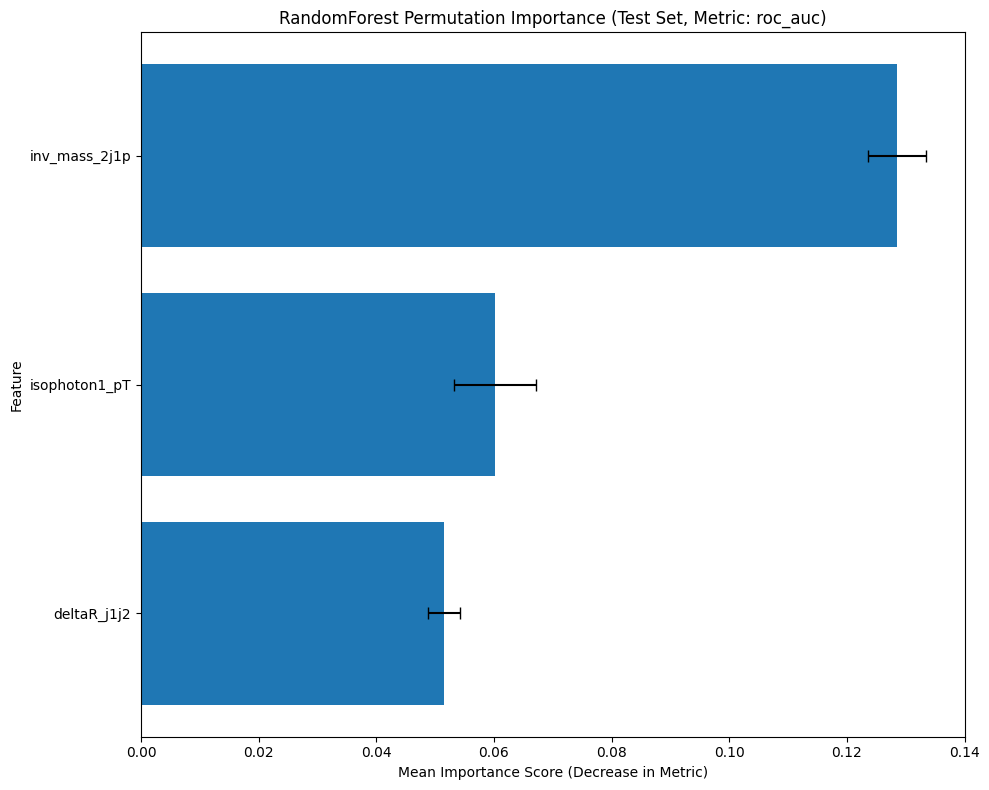

In [23]:
print("\n--- Calculating Permutation Importance (on Test Set) ---")


# Choose a scoring metric - accuracy, roc_auc, f1, balanced_accuracy etc.
# For imbalanced data, 'roc_auc', 'f1_weighted', or 'balanced_accuracy' are often better than 'accuracy'
scoring_metric = 'roc_auc'

# Calculate permutation importance
# n_repeats: Number of times to shuffle each feature for stability
rf_perm_importance_result = permutation_importance(
    estimator=best_model_RF,
    X=X_test,
    y=y_test,
    scoring=scoring_metric,
    n_repeats=10, # Increase for more stable results, but slower
    random_state=seed,
    n_jobs=-1 # Use multiple cores if available
)

# Extract mean and standard deviation of importance scores
rf_importances_perm_mean = rf_perm_importance_result.importances_mean
rf_importances_perm_std = rf_perm_importance_result.importances_std

# Create a Pandas Series for easy handling
rf_perm_importances = pd.Series(rf_importances_perm_mean, index=features_col)
rf_perm_importances = rf_perm_importances.sort_values(ascending=False)

print(f"\nFeatures Permutation Importance on Test Set, metric='{scoring_metric}'):")
print(rf_perm_importances)

# --- Visualize Permutation Importances ---
plt.figure(figsize=(10, 8))
# Get sorted indices for plotting std deviations correctly
sorted_idx = rf_perm_importances.index
plt.barh(sorted_idx, rf_perm_importances[sorted_idx],
         xerr=rf_importances_perm_std[rf_perm_importances.index.get_indexer(sorted_idx)], # Map std dev to sorted order
         capsize=4)
plt.title(f"RandomForest Permutation Importance (Test Set, Metric: {scoring_metric})")
plt.xlabel("Mean Importance Score (Decrease in Metric)")
plt.ylabel("Feature")
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.tight_layout()
plt.show()

# Feature Importance - GradientBoost


--- Calculating Impurity-Based Feature Importance (MDI) ---
inv_mass_2j1p    0.645447
isophoton1_pT    0.180725
deltaR_j1j2      0.173828
dtype: float64


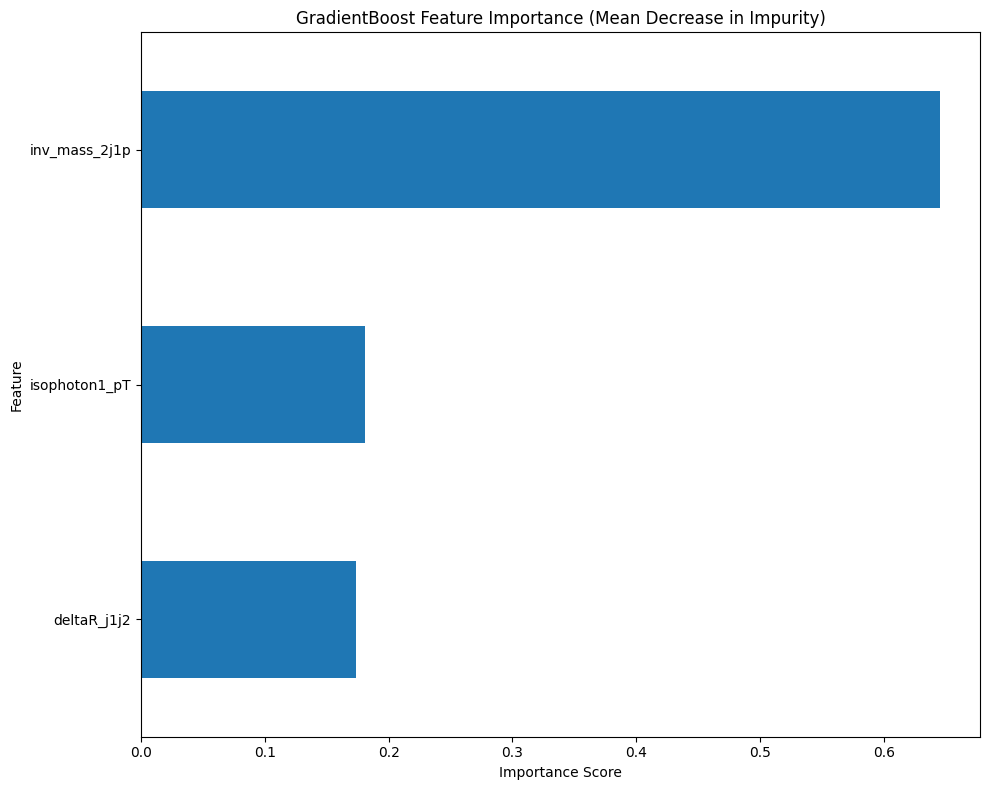

In [24]:
print("\n--- Calculating Impurity-Based Feature Importance (MDI) ---")
# Get importance scores directly from the trained model
gb_importances_mdi = best_model_GB.feature_importances_

# Create a Pandas Series for easy handling and sorting
gb_importances_mdi = pd.Series(gb_importances_mdi, index=features_col)
gb_importances_mdi = gb_importances_mdi.sort_values(ascending=False)

print(gb_importances_mdi)

# --- Visualize MDI Importances ---
plt.figure(figsize=(10, 8))
gb_importances_mdi.plot(kind='barh')
plt.title("GradientBoost Feature Importance (Mean Decrease in Impurity)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.tight_layout()
plt.show()

## Permutation Importance - GradientBoost


--- Calculating Permutation Importance (on Test Set) ---

Features Permutation Importance on Test Set, metric='roc_auc'):
inv_mass_2j1p    0.161626
deltaR_j1j2      0.047523
isophoton1_pT    0.043306
dtype: float64


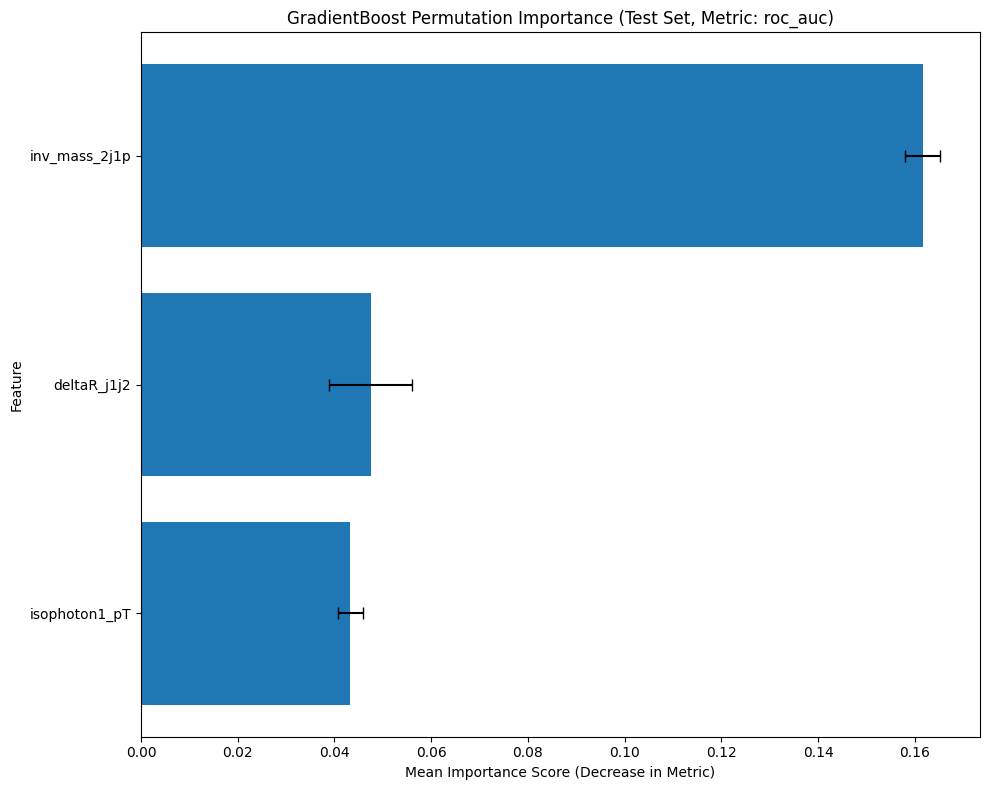

In [25]:
print("\n--- Calculating Permutation Importance (on Test Set) ---")


# Choose a scoring metric - accuracy, roc_auc, f1, balanced_accuracy etc.
# For imbalanced data, 'roc_auc', 'f1_weighted', or 'balanced_accuracy' are often better than 'accuracy'
scoring_metric = 'roc_auc'

# Calculate permutation importance
# n_repeats: Number of times to shuffle each feature for stability
gb_perm_importance_result = permutation_importance(
    estimator=best_model_GB,
    X=X_test,
    y=y_test,
    scoring=scoring_metric,
    n_repeats=10, # Increase for more stable results, but slower
    random_state=seed,
    n_jobs=-1 # Use multiple cores if available
)

# Extract mean and standard deviation of importance scores
gb_importances_perm_mean = gb_perm_importance_result.importances_mean
gb_importances_perm_std = gb_perm_importance_result.importances_std

# Create a Pandas Series for easy handling
gb_perm_importances = pd.Series(gb_importances_perm_mean, index=features_col)
gb_perm_importances = gb_perm_importances.sort_values(ascending=False)

print(f"\nFeatures Permutation Importance on Test Set, metric='{scoring_metric}'):")
print(gb_perm_importances)

# --- Visualize Permutation Importances ---
plt.figure(figsize=(10, 8))
# Get sorted indices for plotting std deviations correctly
sorted_idx = gb_perm_importances.index
plt.barh(sorted_idx, gb_perm_importances[sorted_idx],
         xerr=gb_importances_perm_std[gb_perm_importances.index.get_indexer(sorted_idx)], # Map std dev to sorted order
         capsize=4)
plt.title(f"GradientBoost Permutation Importance (Test Set, Metric: {scoring_metric})")
plt.xlabel("Mean Importance Score (Decrease in Metric)")
plt.ylabel("Feature")
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.tight_layout()
plt.show()